In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import string
import re
import random
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer

#vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#class imbalance handle
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as PL

#split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

#modles
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier


#metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc

#model save
import joblib



import warnings
warnings.filterwarnings("ignore")

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# loading dataset

df = pd.read_csv('train.csv')
df.head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


In [4]:
# dropping 'id' column

df = df.drop('id', axis = 'columns')

In [5]:
df.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [6]:
df.isnull().sum()

label    0
tweet    0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   31962 non-null  int64 
 1   tweet   31962 non-null  object
dtypes: int64(1), object(1)
memory usage: 499.5+ KB


In [8]:
# let's check how many duplicates are there

df.duplicated().value_counts()

False    29530
True      2432
dtype: int64

In [9]:
df.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [10]:
# dropping Duplicates

df = df.drop_duplicates(keep='first')

In [11]:
df.label.value_counts()

0    27517
1     2013
Name: label, dtype: int64

In [12]:
df.duplicated().value_counts()

False    29530
dtype: int64

In [13]:
df.shape

(29530, 2)

## Preprocessing

### Data Cleaning

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
stop_words = stopwords.words('english')

In [16]:
print(len(stop_words))

179


In [17]:
# Lowercase words

def lower_case(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [18]:
# Removing Stopwords

def stop_words_remove(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

In [19]:
# Removing the word 'user'

def remove_word_user(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x != 'user'))

In [20]:
# Lemmatization

Word = WordNetLemmatizer()

def lemmatize(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join([Word.lemmatize(word) for word in x.split()]))

In [21]:
#remove Hyperlinks and Markup

def clean(raw):
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result) # greater than sign
    result = re.sub('&#x27;', "'", result) # apostrophe
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result) # paragraph tag
    result = re.sub('<i>', ' ', result) #italics tag
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub("\n", '', result) # newline
    return result

In [22]:
#remove emoji

def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

In [23]:
#remove punctuation

def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    text = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', text)
    return text

In [24]:
def cleaning(df):
    df['tweet'] = df['tweet'].apply(clean)
    df['tweet'] = df['tweet'].apply(deEmojify)
    df['tweet'] = df['tweet'].apply(lambda x: remove_punct(x))
    lower_case(df)
    stop_words_remove(df)
    remove_word_user(df)
    lemmatize(df)

In [25]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [26]:
cleaning(df)

In [27]:
df.head(20)

,label,tweet
0,0,father dysfunctional selfish drag kid dysfunct...
1,0,thanks lyft credit cant use cause dont offer w...
2,0,bihday majesty
3,0,model love u take u time ur
4,0,factsguide society motivation
5,0,huge fan fare big talking leave chaos pay disp...
6,0,camping tomorrow danny
7,0,next school year year exam cant think school e...
8,0,love land allin cavs champion cleveland clevel...
9,0,welcome im gr


In [28]:
df.shape

(29530, 2)

**Now we check for data imbalance**

In [29]:
df['label'].value_counts()

0    27517
1     2013
Name: label, dtype: int64

In [30]:
pos = 100*len(df.loc[df['label']==0,'label'])/len(df['label'])
neg = 100*len(df.loc[df['label']==1,'label'])/len(df['label'])
print(f'Percentage of Non Hate Speech (Postitive Sentiment) tweets is {pos:.2f}%')
print(f'Percentage of Hate Speech (Negative Sentiment) tweets is {neg: .2f}%')
# print('\nClearly, The data is heavily Imbalanced')

Percentage of Non Hate Speech (Postitive Sentiment) tweets is 93.18%
Percentage of Hate Speech (Negative Sentiment) tweets is  6.82%


### Visualizing The Imbalanced Data

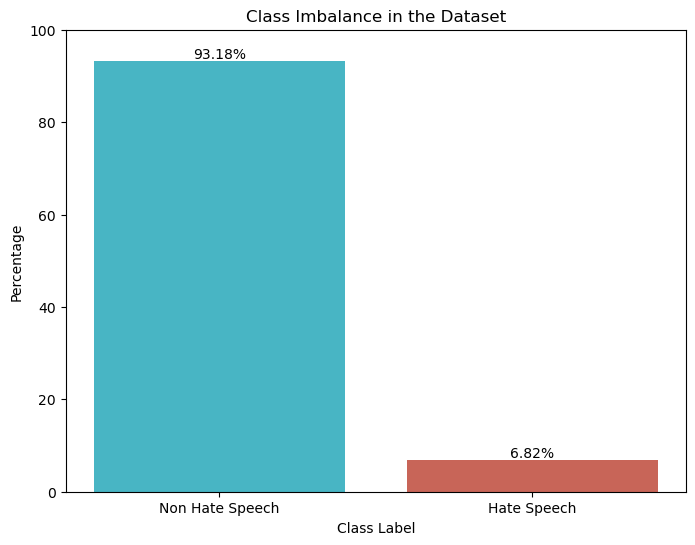

In [31]:
# Data
labels = ['Non Hate Speech', 'Hate Speech']
percentages = [pos, neg]

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(labels, percentages, color=['#48b5c4', '#c86558'])
plt.xlabel('Class Label')
plt.ylabel('Percentage')
plt.title('Class Imbalance in the Dataset')
plt.ylim(0, 100)  # Set the y-axis limit to 0-100 for percentages
# plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Add percentage labels above the bars
for i, p in enumerate(percentages):
    plt.annotate(f'{p:.2f}%', (labels[i], p), ha='center', va='bottom')

# Show the plot
plt.show()

Now, we have to deal with this imbalance. We will now move forward to vectorize the text data.

In [32]:
# Separating data and labels

X = df.drop('label', axis = 'columns')
y = df['label']

In [33]:
X

,tweet
0,father dysfunctional selfish drag kid dysfunct...
1,thanks lyft credit cant use cause dont offer w...
2,bihday majesty
3,model love u take u time ur
4,factsguide society motivation
...,...
31956,fishing tomorrow carnt wait first time year
31957,ate isz youuu
31958,see nina turner airwave trying wrap mantle gen...
31959,listening sad song monday morning otw work sad


In [34]:
y

0        0
1        0
2        0
3        0
4        0
        ..
31956    0
31957    0
31958    0
31959    0
31961    0
Name: label, Length: 29530, dtype: int64

In [35]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_features=10000, ngram_range=(1, 2))
X_tfidf = tfidf_vectorizer.fit_transform(X['tweet'])

# Convert the TFIDF matrix to a DataFrame and concatenate it with the other features
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
X = X.drop('tweet', axis='columns')
X = pd.concat([X.reset_index(drop=True), X_tfidf_df.reset_index(drop=True)], axis='columns')
X = X.fillna(0)

In [36]:
X

,aampe,aap,ab,abandoned,abasel,abba,abc,ability,able,ableism,...,zero,zionazis,zionazis proud,zionism,zionism form,zombie,zone,zoo,zootopia,zoro
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
y

0        0
1        0
2        0
3        0
4        0
        ..
31956    0
31957    0
31958    0
31959    0
31961    0
Name: label, Length: 29530, dtype: int64

In [38]:
X.shape, y.shape

((29530, 10000), (29530,))

In [39]:
# Define SMOTE and RandomUnderSampler
over = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.5)

# Create a pipeline for resampling
steps = [('over', over), ('under', under)]
pipeline = PL(steps=steps)

# Apply the resampling
X, y = pipeline.fit_resample(X, y)

In [40]:
X.shape, y.shape

((33018, 10000), (33018,))

#### Checking the balance again

In [41]:
# let's see the data now

pos = 100 * len(y[y == 0]) / len(y)
neg = 100 * len(y[y == 1]) / len(y)

print(f'Percentage of Not Hate Speech (Positive Sentiment) tweets is {pos: .2f}%')
print(f'Percentage of Hate Speech (Negative Sentiment) tweets is {neg: .2f}%')

Percentage of Not Hate Speech (Positive Sentiment) tweets is  66.67%
Percentage of Hate Speech (Negative Sentiment) tweets is  33.33%


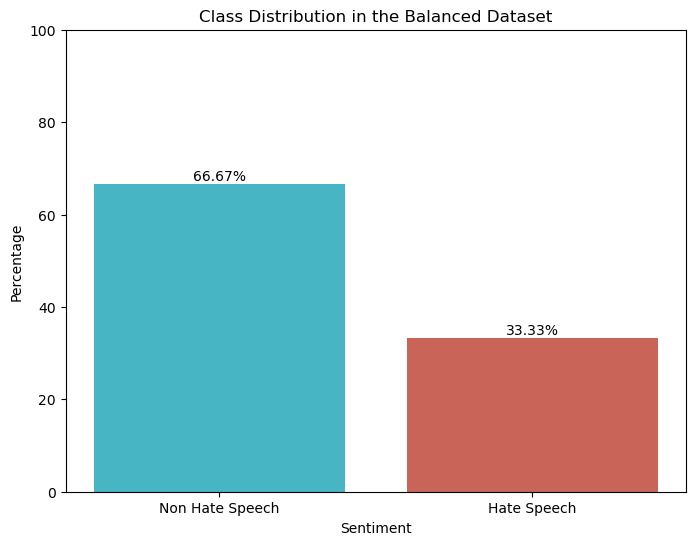

In [42]:
# visualising the data after SMOTE and RandomUnderSampler

# Data
labels = ['Non Hate Speech', 'Hate Speech']
percentages = [pos, neg]

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(labels, percentages, color=['#48b5c4', '#c86558'])
plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.title('Class Distribution in the Balanced Dataset')
plt.ylim(0, 100)  # Set the y-axis limit to 0-100 for percentages

# Add percentage labels above the bars
for i, p in enumerate(percentages):
    plt.annotate(f'{p:.2f}%', (labels[i], p), ha='center', va='bottom')

# Show the plot
plt.show()

In [43]:
# Standard stratified train test split being done here

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,
                                                   test_size = 0.25, stratify=y)

In [44]:
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 24763 samples
Test set: 8255 samples


### Model Training

# Logistic Regression

In [45]:
# Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Perform 5-fold cross-validation on the resampled training set
cv_scores = cross_val_score(logreg, X_train, y_train, cv=5, scoring='accuracy')

print("Logistic Regression:")
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean()}")

# Train the model on the training set
logreg.fit(X_train, y_train)

# Predicting test results
y_pred = logreg.predict(X_test)

# Evaluation

print("Test Accuracy : %.2f" % accuracy_score(y_test, y_pred))
# print("Train Accuracy : %.2f" % accuracy_score(y_train, logreg.predict(X_train)))
print()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

Logistic Regression:
Cross-Validation Scores: [0.92146174 0.92186554 0.9252978  0.92386914 0.92487884]
Mean CV Accuracy: 0.9234746112651168
Test Accuracy : 0.93

Confusion Matrix:
 [[5199  304]
 [ 305 2447]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      5503
           1       0.89      0.89      0.89      2752

    accuracy                           0.93      8255
   macro avg       0.92      0.92      0.92      8255
weighted avg       0.93      0.93      0.93      8255



In [46]:
joblib.dump(logreg, 'logistic_regression_model.pkl')

['logistic_regression_model.pkl']

# Gradient Boosting

In [47]:
# Initialize the model
gb = GradientBoostingClassifier(random_state=42)

# Perform 5-fold cross-validation on the training set
cv_scores = cross_val_score(gb, X_train, y_train, cv=5, scoring='accuracy')

print("Gradient Boosting:") 
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean()}")

# Train the model on the training set
gb.fit(X_train, y_train)

# Predicting test results
gb_pred = gb.predict(X_test)

# Evaluation

print("Test Accuracy : %.2f" % accuracy_score(y_test, gb_pred))
# print("Train Accuracy : %.2f" % accuracy_score(y_train, gb.predict(X_train)))
print()

# Confusion Matrix
cm = confusion_matrix(y_test, gb_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
print("Classification Report:\n", classification_report(y_test, gb_pred))

Gradient Boosting:
Cross-Validation Scores: [0.8223299  0.81788815 0.81990713 0.8111874  0.81603393]
Mean CV Accuracy: 0.8174693002755792
Test Accuracy : 0.82

Confusion Matrix:
 [[5407   96]
 [1412 1340]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.98      0.88      5503
           1       0.93      0.49      0.64      2752

    accuracy                           0.82      8255
   macro avg       0.86      0.73      0.76      8255
weighted avg       0.84      0.82      0.80      8255



In [48]:
joblib.dump(gb, 'gradient_boosting_model.pkl')

['gradient_boosting_model.pkl']

# Random Forest

In [49]:
# Initialize the model
rf = RandomForestClassifier(random_state=42)

# Perform 5-fold cross-validation on the training set
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')

print("Random Forest:")
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean()}")

# Train the model on the training set
rf.fit(X_train, y_train)

# Predicting test results
rf_pred = rf.predict(X_test)

# Evaluation

print("Test Accuracy : %.2f" % accuracy_score(y_test, rf_pred))
# print("Train Accuracy : %.2f" % accuracy_score(y_train, rf.predict(X_train)))
print()

# Confusion Matrix
cm = confusion_matrix(y_test, rf_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
print("Classification Report:\n", classification_report(y_test, rf_pred))

Random Forest:
Cross-Validation Scores: [0.94770846 0.95396729 0.94891985 0.9529483  0.9476979 ]
Mean CV Accuracy: 0.9502483604362428
Test Accuracy : 0.96

Confusion Matrix:
 [[5286  217]
 [ 135 2617]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      5503
           1       0.92      0.95      0.94      2752

    accuracy                           0.96      8255
   macro avg       0.95      0.96      0.95      8255
weighted avg       0.96      0.96      0.96      8255



In [50]:
joblib.dump(rf, 'random_forest_model.pkl')

['random_forest_model.pkl']

# Support Vector Machine (SVM)

In [51]:
# Initialize the model
svm_model = svm.SVC(kernel='linear', random_state=42)

# Perform 5-fold cross-validation on the training set
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=5, scoring='accuracy')

print("Support Vector Machine (SVM)")
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean()}")

# Train the model on the training set
svm_model.fit(X_train, y_train)

# Predicting test results
svm_pred = svm_model.predict(X_test)

# Evaluation

print("Test Accuracy : %.2f" % accuracy_score(y_test, svm_pred))
# print("Train Accuracy : %.2f" % accuracy_score(y_train, svm_model.predict(X_train)))
print()

# Confusion Matrix
cm = confusion_matrix(y_test, svm_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
print("Classification Report:\n", classification_report(y_test, svm_pred))

Support Vector Machine (SVM)
Cross-Validation Scores: [0.92327882 0.92449021 0.93095094 0.9220517  0.92790792]
Mean CV Accuracy: 0.9257359159948427
Test Accuracy : 0.93

Confusion Matrix:
 [[5068  435]
 [ 140 2612]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.92      0.95      5503
           1       0.86      0.95      0.90      2752

    accuracy                           0.93      8255
   macro avg       0.92      0.94      0.92      8255
weighted avg       0.93      0.93      0.93      8255



In [52]:
joblib.dump(svm_model, 'svm_model.pkl')

['svm_model.pkl']

# Naive Bayes

In [53]:
# Initialize the model
nb = MultinomialNB()

# Perform 5-fold cross-validation on the training set
cv_scores = cross_val_score(nb, X_train, y_train, cv=5, scoring='accuracy')

print("Naive Bayes")
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean()}")

# Train the model on the training set
nb.fit(X_train, y_train)

# Predicting test results
nb_pred = nb.predict(X_test)

# Evaluation

print("Test Accuracy : %.2f" % accuracy_score(y_test, nb_pred))
# print("Train Accuracy : %.2f" % accuracy_score(y_train, nb.predict(X_train)))
print()

# Confusion Matrix
cm = confusion_matrix(y_test, nb_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
print("Classification Report:\n", classification_report(y_test, nb_pred))

Naive Bayes
Cross-Validation Scores: [0.85261458 0.85544115 0.859681   0.85541195 0.85420032]
Mean CV Accuracy: 0.8554698006169137
Test Accuracy : 0.86

Confusion Matrix:
 [[5270  233]
 [ 914 1838]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.96      0.90      5503
           1       0.89      0.67      0.76      2752

    accuracy                           0.86      8255
   macro avg       0.87      0.81      0.83      8255
weighted avg       0.86      0.86      0.86      8255



In [54]:
joblib.dump(nb, 'multinomial_naive_bayes_model.pkl')

['multinomial_naive_bayes_model.pkl']

In [55]:
# Make dataframes to plot


logreg_df = pd.DataFrame(data=[f1_score(y_test, y_pred), accuracy_score(y_test, y_pred), recall_score(y_test, y_pred),
                               precision_score(y_test, y_pred), roc_auc_score(y_test, y_pred)],
                         columns=['Logistic Regression Score'],
                         index=["F1", "Accuracy", "Recall", "Precision", "ROC AUC Score"])


gb_df = pd.DataFrame(data=[f1_score(y_test, gb_pred), accuracy_score(y_test, gb_pred), recall_score(y_test, gb_pred),
                           precision_score(y_test, gb_pred), roc_auc_score(y_test, gb_pred)], 
                     columns=['Gradient Boosting Score'],
                     index=["F1", "Accuracy", "Recall", "Precision", "ROC AUC Score"])


rf_df = pd.DataFrame(data=[f1_score(y_test, rf_pred), accuracy_score(y_test, rf_pred), recall_score(y_test, rf_pred),
                           precision_score(y_test, rf_pred), roc_auc_score(y_test, rf_pred)], 
                     columns=['Random Forest Score'],
                     index=["F1", "Accuracy", "Recall", "Precision", "ROC AUC Score"])


svm_df = pd.DataFrame(data=[f1_score(y_test, svm_pred), accuracy_score(y_test, svm_pred), recall_score(y_test, svm_pred),
                           precision_score(y_test, svm_pred), roc_auc_score(y_test, svm_pred)], 
                     columns=['Support Vector Machine (SVM) Score'],
                     index=["F1", "Accuracy", "Recall", "Precision", "ROC AUC Score"])



nb_df = pd.DataFrame(data=[f1_score(y_test, nb_pred), accuracy_score(y_test, nb_pred), recall_score(y_test, nb_pred),
                           precision_score(y_test, nb_pred), roc_auc_score(y_test, nb_pred)], 
                     columns=['Naive Bayes Score'],
                     index=["F1", "Accuracy", "Recall", "Precision", "ROC AUC Score"])


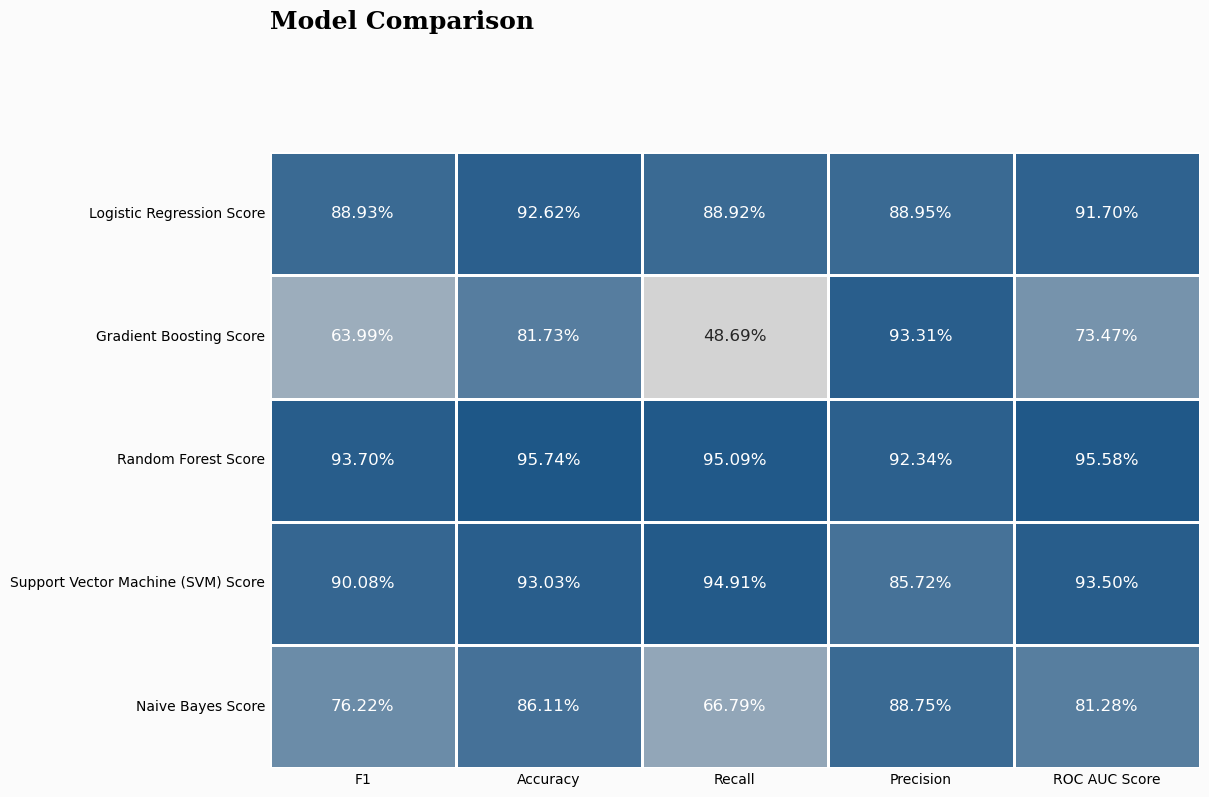

In [56]:
# Combine all model metrics into one DataFrame
df_models = pd.concat([logreg_df, gb_df, rf_df, svm_df, nb_df], axis=1)

# Plotting
import matplotlib

colors = ["lightgray", "lightgray", "#0f4c81"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

background_color = "#fbfbfb"

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)

sns.heatmap(df_models.T, cmap=colormap, annot=True, fmt=".2%", vmin=0, vmax=1, linewidths=1, cbar=False,
            ax=ax, annot_kws={"fontsize": 12})
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

ax.text(0, -1, 'Model Comparison', fontsize=18, fontweight='bold', fontfamily='serif')
ax.tick_params(axis=u'both', which=u'both', length=0)

plt.show()

### ROC AUC Curve

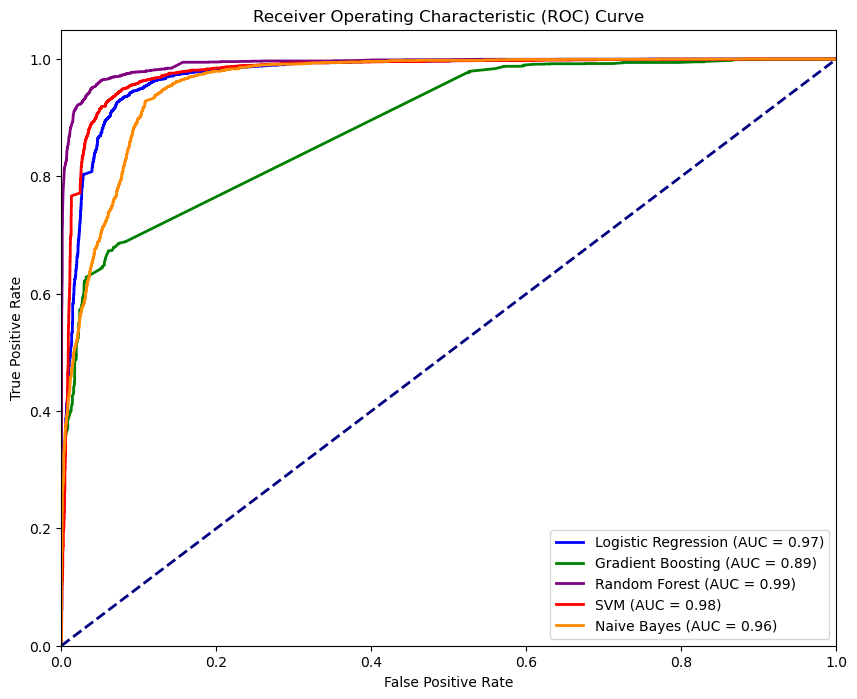

In [60]:
# Calculate ROC curve and AUC for each model
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg.predict_proba(X_test)[:, 1])
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

fpr_gb, tpr_gb, _ = roc_curve(y_test, gb.predict_proba(X_test)[:, 1])
roc_auc_gb = auc(fpr_gb, tpr_gb)

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_model.decision_function(X_test))
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_nb, tpr_nb, _ = roc_curve(y_test, nb.predict_proba(X_test)[:, 1])
roc_auc_nb = auc(fpr_nb, tpr_nb)

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

plt.plot(fpr_logreg, tpr_logreg, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_logreg:.2f})')
plt.plot(fpr_gb, tpr_gb, color='green', lw=2, label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})')
plt.plot(fpr_rf, tpr_rf, color='purple', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_svm, tpr_svm, color='red', lw=2, label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot(fpr_nb, tpr_nb, color='darkorange', lw=2, label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Precession Recall curve

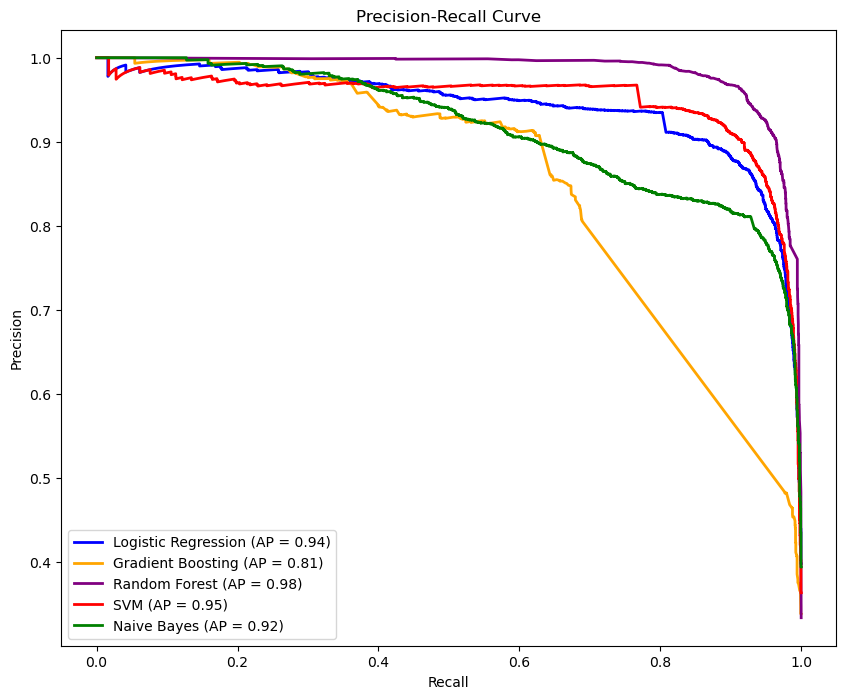

In [58]:
# Calculate Precision-Recall curve and Average Precision (AP) for each model

# Logistic Regression
precision_lr, recall_lr, _ = precision_recall_curve(y_test, logreg.predict_proba(X_test)[:, 1])
ap_lr = average_precision_score(y_test, logreg.predict_proba(X_test)[:, 1])

# Gradient Boosting
precision_gb, recall_gb, _ = precision_recall_curve(y_test, gb.predict_proba(X_test)[:, 1])
ap_gb = average_precision_score(y_test, gb.predict_proba(X_test)[:, 1])

# Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf.predict_proba(X_test)[:, 1])
ap_rf = average_precision_score(y_test, rf.predict_proba(X_test)[:, 1])

# Support Vector Machine (SVM)
precision_svm, recall_svm, _ = precision_recall_curve(y_test, svm_model.decision_function(X_test))
ap_svm = average_precision_score(y_test, svm_model.decision_function(X_test))

# Naive Bayes
precision_nb, recall_nb, _ = precision_recall_curve(y_test, nb.predict_proba(X_test)[:, 1])
ap_nb = average_precision_score(y_test, nb.predict_proba(X_test)[:, 1])

# Plot Precision-Recall curves for all models
plt.figure(figsize=(10, 8))

plt.plot(recall_lr, precision_lr, color='blue', lw=2, label=f'Logistic Regression (AP = {ap_lr:.2f})')
plt.plot(recall_gb, precision_gb, color='orange', lw=2, label=f'Gradient Boosting (AP = {ap_gb:.2f})')
plt.plot(recall_rf, precision_rf, color='purple', lw=2, label=f'Random Forest (AP = {ap_rf:.2f})')
plt.plot(recall_svm, precision_svm, color='red', lw=2, label=f'SVM (AP = {ap_svm:.2f})')
plt.plot(recall_nb, precision_nb, color='green', lw=2, label=f'Naive Bayes (AP = {ap_nb:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()